In [181]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

### A Recursive Feature Elimination (RFE) model with automatic tuning of the number of features selected with cross-validation.

In [164]:
file_names = ['flux_soc_out', 'atmosphere_out', 'n_flux_out', 'p_flux_out', 'soil_c_out', 'soil_water_out', 'surf_water_out', 'temp_out']

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']
target = 'CO2_FLUX'
target_soil = ['ECO_CO2_FLUX', 'SOIL_CO2_FLUX']

In [165]:
def load_datasets(dirs: list) -> dict:
    datasets = {}
    for dr in dirs:
        path = 'datasets/' + dr + '/daily_data_merged'
        flux_soc = pd.read_csv(os.path.join(path, file_names[0] + '.csv'))
        atm = pd.read_csv(os.path.join(path, file_names[1] + '.csv'))
        nitrogen = pd.read_csv(os.path.join(path, file_names[2] + '.csv'))
        phosp = pd.read_csv(os.path.join(path, file_names[3] + '.csv'))
        soil_carbon = pd.read_csv(os.path.join(path, file_names[4] + '.csv'))
        soil_water = pd.read_csv(os.path.join(path, file_names[5] + '.csv'))
        surf_water = pd.read_csv(os.path.join(path, file_names[6] + '.csv'))
        temp = pd.read_csv(os.path.join(path, file_names[7] + '.csv'))

        flux_soc = flux_soc.drop(flux_soc.columns[0], axis=1)
        atm = atm.drop(atm.columns[0], axis=1)
        nitrogen = nitrogen.drop(nitrogen.columns[0], axis=1)
        phosp = phosp.drop(phosp.columns[0], axis=1)
        soil_carbon = soil_carbon.drop(soil_carbon.columns[0], axis=1)
        soil_water = soil_water.drop(soil_water.columns[0], axis=1)
        surf_water = surf_water.drop(surf_water.columns[0], axis=1)
        temp = temp.drop(temp.columns[0], axis=1)

        csv_list = [flux_soc, atm, nitrogen, phosp, soil_carbon, soil_water, surf_water, temp]

        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[file_names[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

datasets = load_datasets(dirs)

In [166]:
def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df
# turn all csv's to one dataframe

def to_pd(df: dict, handle_dupes: bool) -> pd.DataFrame:
    dup_cols = ['ICE_13','WTR_5','SEDIMENT','WTR_8','WTR_7','ACTV_LYR','WTR_TBL','WTR_6','WTR_4','ICE_7','WTR_3','WTR_2','WTR_1','SNOWPACK','DISCHG','RUNOFF','WTR_9','WTR_10','WTR_11','WTR_12','WTR_13','SURF_WTR','ICE_1','ICE_2','ICE_3','ICE_4','ICE_5','SURF_ICE','ICE_6','ICE_12','ICE_11','ICE_10','ICE_9','PRECN','WIND','ICE_8','O2_FLUX','CH4_FLUX']
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
        
        if handle_dupes:
            dupes = [col for col in cur.columns if col in dup_cols]
            
            if file_name == 'soil_water_out' or file_name == 'flux_soc_out':
                cur = rename_dupes('_SOIL', cur, dupes)
            elif file_name == 'surf_water_out':
                cur = rename_dupes('_SURF', cur, dupes)
            elif file_name == 'atmosphere_out':
                cur = rename_dupes('_ATM', cur, dupes)
            
        x = pd.concat([x, df[file_name]], axis = 1)
    x = x.drop(['DATE'], axis=1)
    cheeky_bstrd = 'unnamed.1' 
    if cheeky_bstrd in x.columns:
        x = x.drop([cheeky_bstrd], axis=1)

    return x

x = to_pd(datasets['warm_temp_maize_soybean_irrigated'], True)
y = x[target].copy()
x = x.drop(target,axis = 1)

In [167]:
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportanceCO2_FLUX.csv')

In [168]:
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])
    
feat_cols.remove('HUM_CAN_AIR')
x = x[feat_cols]

In [169]:
min_features_to_select = 1  # Minimum number of features to consider

lmbdas = [i/2 for i in range(1,25)]
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
clf = RidgeCV(alphas=lmbdas, cv=cv, scoring='neg_mean_squared_error')

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(x, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 73


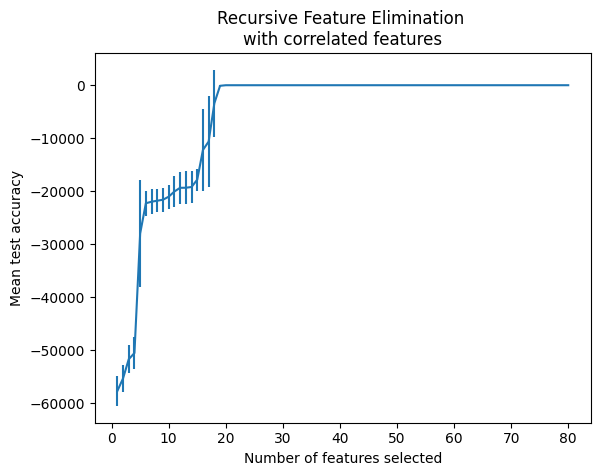

In [171]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [172]:
importances = pd.DataFrame({'RANK': rfecv.ranking_}, index=rfecv.feature_names_in_).sort_values(by='RANK', ascending=False)

In [173]:
importances

,RANK
CH4_13,8
CH4_12,7
CH4_11,6
CH4_10,5
CH4_8,4
...,...
TMAX_AIR,1
NO3_5,1
NO3_10,1
ICE_1_SOIL,1


In [196]:
x_dry = to_pd(datasets['warm_temp_maize-soybean_dryland'], True)
y_dry = x_dry[target].copy()
x_dry = x_dry.drop(target,axis = 1)

In [197]:
x_dry = x_dry[feat_cols]

In [198]:
pred = rfecv.predict(x_dry)

RMSE :  15.700610


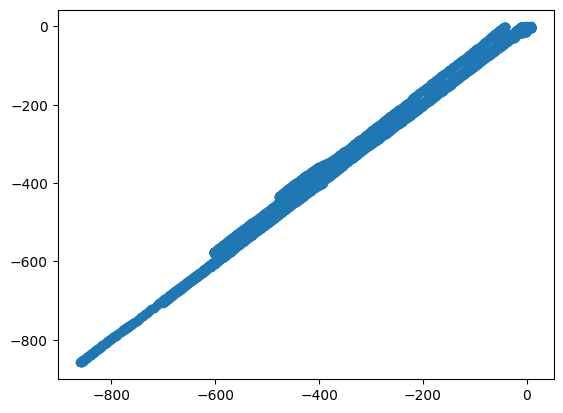

In [199]:
# RMSE Computation
rmse = np.sqrt(MSE(y_dry, pred))
print("RMSE : % f" %(rmse))
plt.scatter(pred, y_dry)

In [188]:
x_cool = to_pd(datasets['cool_temp_maize_soybean'], True)
y_cool = x_cool[target].copy()
x_cool = x_cool.drop(target,axis = 1)

In [ ]:
x_cool = x_cool[feat_cols]

In [194]:
pred_col = rfecv.predict(x_cool)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ACTV_LYR_SOIL
- AMENDED_C
- ATM_CO2
- CH4_15
- CO2_2
- ...
Feature names seen at fit time, yet now missing:
- CH4_10
- CH4_11
- CH4_12
- CH4_13
- CH4_4
- ...


In [193]:
# RMSE Computation
rmse = np.sqrt(MSE(y_cool, pred_col))
print("RMSE : % f" %(rmse))
plt.scatter(pred_col, y_dry)

ValueError: Found input variables with inconsistent numbers of samples: [2557, 2556]

In [ ]:
for i in range(x.shape[1]):
 print('Column: %s, Selected %s, Rank: %.3f' % (rfecv.feature_names_in_[i], rfecv.support_[i], rfecv.ranking_[i]))